# Speaker-Independent Spoken Digit Recognition (xSDR)


One of the successful stories of deep neural networks is the proliferation of commercial of automatic speech recognition (ASR) systems. This project aims to explore one application of ML-powered ASR to the problem of spoken digit recognition (SDR). Since digits are widely used as unique identifiers for bank information, social security numbers, post codes, etc, SDR systems can be an efficient alternative to fully-fledged ASR systems since the domain is more predictable than other applications of ASR. 

In this project, we focus on developing a SDR system in a speaker-independent setting. That is, the speakers in the evaluation set are disjoint from the training set speakers. We do so because we expect real-world ASR systems to generalize to different speakers than those we have data for. Moreover, for many languages that are under-resourced, we have have (limited) annotated speech data from a single speaker, but we would still want the system to be deployed to work on any speaker of that language. We tackle the problem of spoken digit recognition as a sequence classification task. Concretely, the inputs are short audio clips of a specific digit (in the range 0-9), then the goal is to build deep neural network models to classify a short audio clip and predict the digit that was spoken.

In [1]:
#%matplotlib inline
import numpy as np
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import skimage.measure
import pandas as pd

from sklearn  import preprocessing

from collections import defaultdict, Counter

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')

import random

import torchaudio
import math
import os
import pathlib
import torch

In [2]:
# for linear models 
from sklearn.linear_model import SGDClassifier, Ridge, LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


In [3]:
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
from sklearn.neural_network import MLPClassifier

In [5]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D, Flatten
import tensorflow as tf
# import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import keras 
from keras.utils import to_categorical
from keras import layers

2023-03-28 23:35:21.350605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
!pip install transformers
from transformers import ASTForAudioClassification

In [7]:
!pip install deepsig
from deepsig import multi_aso 

In [8]:
!pip install tensorflow-addons

## Exploring the Dataset 

The speech samples are already divied into training, development, and test spilts. The splits are made in such way that evaluation speakers are not present in training split. You should use the splits as they are. 

**CAUTION:** 

In this project, you are not allowed to use any external data for this problem (at least for the main three tasks). Exploring the effect of additional datasets in this project can only included as a further step after completing the main requirements with the given data. 

In [9]:
# read tsv file into a dataframe 
# from google.colab import drive 
# drive.mount('/content/drive')
# change path to your own drive
# path = "/content/drive/MyDrive/colab_data/"
path = ''
sdr_df = pd.read_csv(path + 'SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

In [10]:
sdr_df.head()

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
1,2_yweweler_39,yweweler,TEST,2,speech_data/2_yweweler_39.wav
2,6_yweweler_34,yweweler,DEV,6,speech_data/6_yweweler_34.wav
3,6_yweweler_16,yweweler,DEV,6,speech_data/6_yweweler_16.wav
4,9_yweweler_2,yweweler,TEST,9,speech_data/9_yweweler_2.wav


In [76]:
set(sdr_df.speaker.unique())

{'george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'}

In [79]:
speakers = sdr_df.speaker.unique()
splits = sdr_df.split.unique()
labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
# print(speakers, splits, labels)
analysis_output = {}

for speaker in speakers:
    for split in splits:
        for label in labels:
            
            print(f'speaker {speaker}, split {split}, label {label}, num_val {len(sdr_df.loc[(sdr_df["speaker"]==speaker) & (sdr_df["split"]==split) & (sdr_df["label"]==label)])}')
            

speaker theo, split TRAIN, label 0, num_val 50
speaker theo, split TRAIN, label 1, num_val 50
speaker theo, split TRAIN, label 2, num_val 50
speaker theo, split TRAIN, label 3, num_val 50
speaker theo, split TRAIN, label 4, num_val 50
speaker theo, split TRAIN, label 5, num_val 50
speaker theo, split TRAIN, label 6, num_val 50
speaker theo, split TRAIN, label 7, num_val 50
speaker theo, split TRAIN, label 8, num_val 50
speaker theo, split TRAIN, label 9, num_val 50
speaker theo, split TEST, label 0, num_val 0
speaker theo, split TEST, label 1, num_val 0
speaker theo, split TEST, label 2, num_val 0
speaker theo, split TEST, label 3, num_val 0
speaker theo, split TEST, label 4, num_val 0
speaker theo, split TEST, label 5, num_val 0
speaker theo, split TEST, label 6, num_val 0
speaker theo, split TEST, label 7, num_val 0
speaker theo, split TEST, label 8, num_val 0
speaker theo, split TEST, label 9, num_val 0
speaker theo, split DEV, label 0, num_val 0
speaker theo, split DEV, label 1, nu

In [48]:
# explore one sample: 7_theo_0
sdr_df.loc[sdr_df['identifier'] == '7_theo_0']

,identifier,speaker,split,label,file
700,7_theo_0,theo,TRAIN,7,speech_data/7_theo_0.wav


In [49]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]

## The Speech Waveform

The acoustic realization of speech segment can be (digitally) viewed as a time-variant wavform $\mathbf{S} \in \mathbb{R}^{n}$. Here, $n$ depends on both the duration of the speech segment and the sampling rate of the continous speech singal. Let's check out one sample from the data set. 

In [50]:
# play and listen to a sample 
SAMPLING_RATE = 8000 # This value is determined by the wav file, DO NOT CHANGE

x, sr = librosa.load(path + sample_wav_file, sr=SAMPLING_RATE) #, 
ipd.Audio(x, rate=sr)

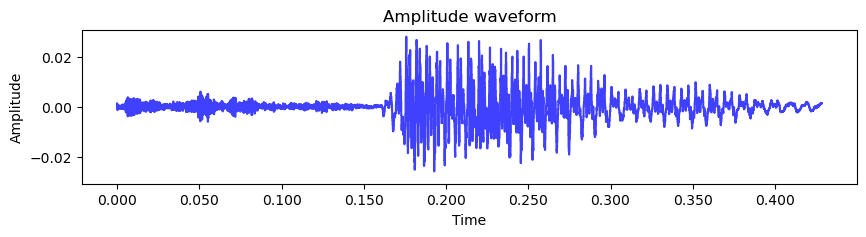

In [51]:
# plot as a waveform 
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [52]:
# sample duration in milliseconds
(1000*len(x))/SAMPLING_RATE

428.5

In the cell above, you can see the temporal duration of the audio is 428.5 milliseconds. For digits in the range 0-9, the duration of the speech segment should be around 0.5 seconds with reasonable variation depending on speech rate (i.e., how fast the speaker speaks). 

## The Speech Signal Representation - Mel Spectrograms

Humans can recognize and differentiate different speech sounds based on the frequency characteristics of the sounds. For machine learning applications, human speech is represented using spectro-temporal features in the [Mel-scale](https://en.wikipedia.org/wiki/Mel_scale) extracted from the speech sample. Mel-scale features are inspired by human speech perception and auditory processing whereby the human ear has difference sensitivity (or resolution) in differet frequency bandes. That is, the human ear can better recognize differences in in lower range frequences, while higher range frequences have a lower resolution. The Mel-scale is linear for frequencies in the range (0-1kHz), and logarithmic for frequencies above 1kHz.

In the spectro-temporal representation of speech, a speech sample can be seen as a sequence of $T$ spectral vectors as $\mathbf{X} = (\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^T)$. Each spectral vector $\mathbf{x}^t \in \mathbb{R}^{k}$ at time-step $t$ is extracted from a short speech segment (~25 milliseconds) with the assumption that the signal is time-invariant in this small time window. Here, $k$ is the number of frequency bands in the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) and this is a parameter of the feature extraction pipeline. The representation is based on the Fourier transform to convert the temporal signal into the frequency domain. 

In automatic speech recognition (ASR) research and applications, spectral vectors are usually referred to as "acoustic frames". Morover, adjacent frames are extracted with some overlap between them, usually ~10 milliseconds. 

In [53]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr), 
    and the number of mel coefficients, return a mel-scaled 
    representation of the signal as numpy array.
    """
    
    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )
    
    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)
    
    return scaled_log_mel_features

In [54]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=13)

melspectrogram.shape

(13, 43)

Note that the shape of the array (K x T) represents the number of frequency bands (K) and the number of spectral vectors in this representation (here, K=13, T=43). K is a hyperparameter and the recommended values in ASR research are (13, 39, 81, etc). Here, we fix K = 13. On the other hand, T varies from sample to sample depending on the duration of the sample.  

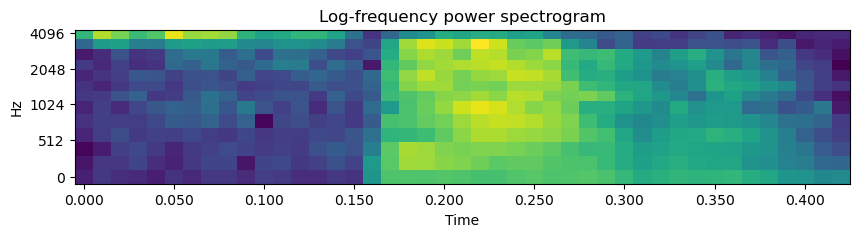

In [55]:
# plot and view the spectrogram

fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.specshow(
    melspectrogram, 
    sr=sr, 
    x_axis='time', 
    y_axis='mel', 
    cmap='viridis', 
    fmax=4000, 
    hop_length=80
)

ax.set(title='Log-frequency power spectrogram')

ax.label_outer()

As you can see above from the figure, the spectrogram representation can be viewed as a matrix $\mathbf{X} \in \mathbb{R}^{T} \times \mathbb{R}^{k}$.  

## Task I
1. One problem with the spectrogram as a speech feature represetation is that different speech samples would have dfferent durations due to inherent speech variability (e.g., speech rate, speaker dialect, etc). That is, the $T$ in the $(T \times k)$-dimensional representation would be different for each sample. Therefore, for the baseline model, we will implement a method to have a fixed-size representation for all speech samples. Write a function downsample_spectrogram(X, N) that takes as input a spectrogram $\mathbf{X} \in \mathbb{R}^{T \times k}$ and a parameter N <= 25. The function should (1) make N equally-sized splits of S across the time-axis, (2) apply a pooling technique (e.g., mean pooling) to each split across the frequency axis to obtain an array that represents a downsampled version of the spectrogram $\mathbf{X}' \in \mathbb{R}^{N \times k}$, and (3) re-arange $\mathbf{X}'$ as a vector $\mathbf{v} \in \mathbb{R}^{Nk}$.    

2. Using the downsample_spectrogram(X, N) function, transform all the speech samples into vectors $\mathbf{v} \in \mathbb{R}^{Nk}$. 

3. Given the speaker-based train/dev/test spilts in the SDR_metadata.tsv, fit a linear model on the training samples. That is, your model should be build on data from 4 speakers {'nicolas', 'theo' , 'jackson',  'george'}. Hint: you can experiment with a few model alternatives in the SGDClassifier module in scikit-learn. 

4. Evaluate you model on the dev and test splits. Use accuracy as an evaluation metric. Analyze the model performance using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of the all possible labels (0-9), Analyze [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [F1-score](https://en.wikipedia.org/wiki/F-score) for each label. Report your observation.

In [56]:
def ResampleLinear1D(row, N: int): 
    # validation
    if N > 25:
        N = 25
    if N < 1:
        N = 1

    # row is a list, need it to be np.array
    row = np.array(row, dtype=np.float)
    # create new spacing
    index_arr = np.linspace(0, row.shape[0]-1, num=N, dtype=np.float)
    
    index_floor = np.floor(index_arr).astype(np.int) # np.int as they'll return them as np.float types
    index_ceil = index_floor + 1 
    index_rem = index_arr - index_floor 
    interp = (row[index_floor] * (1.0 - index_rem)) + \
                (row[index_ceil % row.shape[0]] * index_rem)
    return interp

def downsample_spectrogram(X, N):
    """
    Given a spectrogram of an arbitrary length/duration (X ∈ K x T), 
    return a downsampled version of the spectrogram v ∈ K * N
    """
    # use a for loop to downsample the array along the columns
    downsampled_arr = []
    for row in X:
        downsampled_row = ResampleLinear1D(row, N)
        downsampled_arr.append(downsampled_row)

    v = np.array(downsampled_arr).flatten()
     
    return v

## Baseline Model

In [130]:
# prepare data and split
def downsaple_all_data(sdr_df, N = 25, names = {}, in_label = None):
  train_X = []
  dev_X = []
  test_X = []

  train_Y = []
  dev_Y = []
  test_Y = []

  for index, row in sdr_df.iterrows():
      sample_wav_file = row["file"]
      x, sr = librosa.load(path + sample_wav_file, sr=SAMPLING_RATE) #, 
      melspectrogram = extract_melspectrogram(x, sr, num_mels=13)
      
      downsample = downsample_spectrogram(melspectrogram, N)
      label = row["label"]
      split = row["split"]
      # when we want only a certain number
      if in_label is not None:
         if in_label != label:
            continue
         
      # when we wish to have only a few speakers
      if len(names) != 0:
        speaker = row["speaker"]


        if split == "TRAIN" and speaker in names:
            train_X.append(downsample)
            train_Y.append(label)
      else:
        if split == "TRAIN":
            train_X.append(downsample)
            train_Y.append(label)
      
      if split == "DEV":
          dev_X.append(downsample)
          dev_Y.append(label)
          
      if split == "TEST":
          test_X.append(downsample)
          test_Y.append(label)

  train_X = np.array(train_X)
  train_Y = np.array(train_Y)

  dev_X = np.array(dev_X)
  dev_Y = np.array(dev_Y)

  test_X = np.array(test_X)
  test_Y = np.array(test_Y)
    
  return train_X, dev_X, test_X, train_Y, dev_Y, test_Y



In [80]:
sdr = sdr_df.copy()
sdr = sdr.drop('speaker', axis=1)

In [84]:
train_X, dev_X, test_X, train_y, dev_y, test_y = downsaple_all_data(sdr)

In [135]:
train_1_X, dev_1_X, test_1_X, train_1_y, dev_1_y, test_1_y = downsaple_all_data(sdr_df=sdr, in_label=1) 
train_7_X, dev_7_X, test_7_X, train_7_y, dev_7_y, test_7_y = downsaple_all_data(sdr_df=sdr, in_label=7) 

In [157]:
train_1_X_george, dev_1_X_george, test_1_X_george, train_1_y_george, dev_1_y_george, test_1_y_george = downsaple_all_data(sdr_df=sdr_df, in_label=1, names={'george'}) 
train_1_X_jackson, dev_1_X_jackson, test_1_X_jackson, train_1_y_jackson, dev_1_y_jackson, test_1_y_jackson = downsaple_all_data(sdr_df=sdr_df, in_label=1, names={'jackson'}) 
train_1_X_nicolas, dev_1_X_nicolas, test_1_X_nicolas, train_1_y_nicolas, dev_1_y_nicolas, test_1_y_nicolas = downsaple_all_data(sdr_df=sdr_df, in_label=1, names={'nicolas'}) 
train_1_X_theo, dev_1_X_theo, test_1_X_theo, train_1_y_theo, dev_1_y_theo, test_1_y_theo = downsaple_all_data(sdr_df=sdr_df, in_label=1, names={'theo'}) 
train_1_X_lucas, dev_1_X_lucas, test_1_X_lucas, train_1_y_lucas, dev_1_y_lucas, test_1_y_lucas = downsaple_all_data(sdr_df=sdr_df, in_label=1, names={'lucas'}) 
train_1_X_yweweler, dev_1_X_yweweler, test_1_X_yweweler, train_1_y_yweweler, dev_1_y_yweweler, test_1_y_yweweler = downsaple_all_data(sdr_df=sdr_df, in_label=1, names={'yweweler'}) 

In [ ]:
X_partial_train, X_partial_dev, X_partial_test, y_partial_train, y_partial_dev, y_partial_test = downsaple_all_data(sdr, names={'nicolas', 'theo' , 'jackson',  'george'})

In [ ]:
X_george_train, X_george_dev, X_george_test, y_george_train, y_george_dev, y_george_test = downsaple_all_data(sdr, names={'george'})

In [ ]:
# train a linear model 
sgd = SGDClassifier(loss='log_loss', penalty='elasticnet').fit(X_partial_train, y_partial_train)
lr = LogisticRegression(solver='saga', multi_class = 'ovr').fit(X_partial_train, y_partial_train)

In [ ]:
# evaluate the model using accuracy metric
dev_pred_sgd = sgd.predict(X_partial_dev).astype("int")
dev_pred_lr = lr.predict(X_partial_dev).astype("int")

score_sgd = accuracy_score(y_partial_dev, dev_pred_sgd)
score_lr = accuracy_score(y_partial_dev, dev_pred_lr)
print(f'SGDClassifier score {score_sgd}, LogisticRegression score {score_lr}')

In [ ]:
# analyze the confusion matrix of the baseline
cm_sgd = confusion_matrix(y_partial_dev, dev_pred_sgd)
cm_lr = confusion_matrix(y_partial_dev, dev_pred_lr)
print('SGD_CM: ', cm_sgd)
print('SGD_LR: ', cm_lr)

In [ ]:
# recall_score(dev_Y, dev_pred_reg, average="macro")
print('SGD_Recall: ', recall_score(y_partial_dev, dev_pred_sgd, average="macro"))
print('LR_Recall: ', recall_score(y_partial_dev, dev_pred_lr, average="macro"))

In [ ]:
# f1_score(dev_Y, dev_pred_reg, average="macro")
print('SGD_f1: ', f1_score(y_partial_dev, dev_pred_sgd, average="macro"))
print('LR_f1: ', f1_score(y_partial_dev, dev_pred_lr, average="macro"))

## Task II
1. Having established a baseline with a linear model trained on a downsampled signal representation of the speech segment, this task aims to learn a classifier based on the full speech segment. To this end, you will implement a neural model that is suitable for sequential data such as recurrent DNN, convolutional DNN with 1-D temporal convolution, or an audio transformer. The model should take the acoustic sample as it is (i.e., the Mel spectrogram could have an arbitrary length) without the need to downsample the segment. You need to implement at least two of the aforementioned models. Do the neural models improve accuracy over the baseline model? Do you observe any signs of overfitting to the training data? How do the hyperparameters affect the model performance? Report and discuss your observations.        

2. Evaluate your (best) neural models and compare to the baseline model using the same evalution process as in task I.4. 

3. Use a dimensionality reduction algorithm such as t-SNE \[[1](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding),[2](https://pypi.org/project/tsne-torch/),[3](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)\] or [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) to analyze how the different models seperate the different classes (the last non-linear layer in your model). Compare to the downsampled representation you used in the baseline and report your observations.

4. Are the differences between the different models statistically significant? To answer this question, you need to implement a statistical significance test based on bootstrapping method. To read more how to estiame p-values based on bootstrapping, we recommend the materials on this paper https://aclanthology.org/D12-1091.pdf. Include the baseline model in your evaluation. 

LSTM Model, inspired by https://towardsdatascience.com/recurrent-neural-nets-for-audio-classification-81cb62327990

In [86]:
# reshape np.array into 3D
X_train = train_X.reshape(train_X.shape[0],train_X.shape[1],1)

In [87]:
timesteps = X_train.shape[1] # how many values exist in a sequence, dimensionality of the input sequence
n_outputs = 10
units = timesteps # how many LSTM cell we've connected sequentially, at most it's timesteps
epochs = 100

In [88]:
# data is X_train, num_layers is architecture of hidden layers, number and size, and dropout is values for dropout in hidden layers
def get_LSTM(data:np.ndarray, timesteps:int, units:int, num_layers:list(), layer_type:list(), dropout:list(), activation:str):
    '''
        units: number of units in each LSTM cell, usually set to timesteps
        num_layers, layer_type and dropout are with respect to the hidden layer, and need to be of the same length
        num_layers: the number of neurons in each hidden layer
        layer_type: 1 for LSTM, o.w. for Dense
        dropout: self explanatory
    '''
    if len(num_layers) != len(dropout) and (len(num_layers) or len(dropout)) == 0:
        raise Exception('Number of layers and dropout values, has to be the same')
    # input shape is timestamp x 1, since we're feeding them sequentially, i.e. 1 is dimensionality of each input representation in the sequence
    input_shape=(data.shape[1],1) 
    model = keras.Sequential()
    
    # We need to add return_sequences=True for all LSTM layers except the last one.
    # Setting this flag to True lets Keras know that LSTM output should contain all historical generated outputs along with time stamps (3D). 
    # So, next LSTM layer can work further on the data. If this flag is false, then LSTM only returns last output (2D). 
    # Such output is not good enough for another LSTM layer.

    # input layer
    if 1 in layer_type:
        model.add(LSTM(units,input_shape=input_shape, return_sequences=True))
    else:
        model.add(LSTM(units,input_shape=input_shape, return_sequences=False))

    for i in range(len(num_layers)):
        model.add(Dropout(dropout[i])) # applies to the next layer   
        if layer_type[i] == 1:
            if 1 in layer_type[i+1:]:
                model.add(LSTM(units, return_sequences=True))
            else:
                model.add(LSTM(units))
        else:
            model.add(Dense(num_layers[i], activation=activation))

    # output layer
    model.add(Dense(n_outputs, activation='softmax'))
    # model.summary()
    return model

It can be observed that making the network more complex, i.e. increasing the number of hidden layers, increasing the size of the hidden layers, or increasing the number of units, makes it better suited to capture more complex relations between the output and input. This risks the network overfitting the training dataset, and having a poor performance on the testing dataset. We can also observe that having dropout improves the networks reliability and accuracy, by having a sort of regularization put in place. And with LSTM, it has been shown that relu and leaky relu don't suffer as much from the issues of exploding/vanishing gradient, as much as the sigmoid and tanh activation functions.

In [89]:
model_lstm = get_LSTM(
    data=X_train, 
    timesteps=timesteps, 
    units=units, 
    num_layers=[128, 128, 64, 16, 2], 
    layer_type=[0, 1, 0, 1, 0], 
    dropout=[0.25, 0.25, 0.25, 0.25, 0.25], 
    activation='relu')

2023-03-29 00:23:44.954436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [90]:
# options for loss are 'categorical_hinge', 'SparseCategoricalCrossentropy', 'tf.keras.losses.Hinge', 'CategoricalCrossentropy',..
model_lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [91]:
# one hot encoding for the outputs
encoded_train = to_categorical(train_y)
encoded_test = to_categorical(test_y)
encoded_dev = to_categorical(dev_y)

In [154]:
''' 
    The p value is evidence against the null hypothesis. More precisly said you reject the null hypothesis
    that the two samples were drawn from the same distribution if the p-value is less than your significance level. 
    The significance level of p value is usually set at 0.05.
'''
scipy.stats.ks_2samp(train_X[0], train_X[2], alternative='two-sided', mode='auto')

KstestResult(statistic=0.11076923076923077, pvalue=0.03700954696648946, statistic_location=-0.10673650416235175, statistic_sign=-1)

In [179]:
# will keep the historic results for the acc, loss, val_loss and val_acc 
history = model_lstm.fit(X_train, encoded_train, epochs=100, batch_size=64, validation_data=(dev_X, encoded_dev), shuffle=True)

Epoch 1/20
 5/32 [===>..........................] - ETA: 1:07 - loss: 2.3025 - acc: 0.1281

KeyboardInterrupt: 

In [ ]:
# show data
history_dict_lstm=history.history
loss_values=history_dict_lstm['loss']
acc_values=history_dict_lstm['acc']
val_loss_values = history_dict_lstm['val_loss']
val_acc_values=history_dict_lstm['val_acc']
epoch=range(1,epochs + 1) # need an x-axis
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epoch,loss_values,'co',label='Training Loss')
ax1.plot(epoch,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epoch,acc_values,'co', label='Training accuracy')
ax2.plot(epoch,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [102]:
# but these are one-hot encoded
dev_pred_lstm_encoded = model_lstm.predict(dev_X).astype("int")

16/16 [==============================] - 9s 515ms/step


In [103]:
# turning back into values
dev_pred_lstm=np.argmax(dev_pred_lstm_encoded, axis=1)

In [104]:
score_lstm = accuracy_score(dev_y, dev_pred_lstm)

In [105]:
cm_lstm = confusion_matrix(dev_y, dev_pred_lstm)

In [117]:
dev_pred_lstm.tolist().sort()

In [118]:
dev_pred_lstm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
train_y.tolist()

https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3

In [121]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    # try and fit each distribution
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [138]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(all_1_train)

p value for norm = 1.5689894312539866e-241
p value for exponweib = 2.5002425249780875e-195
p value for weibull_max = 5.747007631707229e-192
p value for weibull_min = 7.099252193886332e-194
p value for pareto = 0.0
p value for genextreme = 4.742599731269761e-192
Best fitting distribution: weibull_max
Best p value: 5.747007631707229e-192
Parameters for the best fit: (3.3888336285846874, 3.0449874038828004, 3.4177419506207185)


In [142]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(george_1_train)

p value for norm = 7.486907866301419e-103
p value for exponweib = 9.83962123873793e-86
p value for weibull_max = 2.883338569348903e-65
p value for weibull_min = 3.443451138186443e-74
p value for pareto = 0.0
p value for genextreme = 2.822056009527433e-65
Best fitting distribution: weibull_max
Best p value: 2.883338569348903e-65
Parameters for the best fit: (2.3855886231430343, 2.2036923525752767, 2.5250080565258117)


In [143]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(jackson_1_train)

p value for norm = 4.805670672618289e-58
p value for exponweib = 0.0
p value for weibull_max = 1.0319212589990532e-23
p value for weibull_min = 2.8268755040977624e-37
p value for pareto = 0.0
p value for genextreme = 9.859240546598261e-24
Best fitting distribution: weibull_max
Best p value: 1.0319212589990532e-23
Parameters for the best fit: (2.328122692820576, 2.1451017461692112, 2.454399390777017)


In [148]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(nicolas_1_train)

p value for norm = 1.800548260433273e-56
p value for exponweib = 4.526445931746673e-40
p value for weibull_max = 9.250867751132676e-47
p value for weibull_min = 8.89384466147027e-75
p value for pareto = 0.0
p value for genextreme = 9.330153160752234e-47
Best fitting distribution: exponweib
Best p value: 4.526445931746673e-40
Parameters for the best fit: (45.139151926012715, 78.10466999529791, -284.3885302974552, 279.1641151345324)


In [153]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(theo_1_train)

p value for norm = 1.0194017987732583e-71
p value for exponweib = 4.462636809996485e-82
p value for weibull_max = 9.310662352335229e-57
p value for weibull_min = 4.796471639419751e-66
p value for pareto = 0.0
p value for genextreme = 9.911102719798118e-57
Best fitting distribution: genextreme
Best p value: 9.911102719798118e-57
Parameters for the best fit: (0.3196151893238057, -0.3487139434048472, 1.0059914811899004)


In [144]:
scipy.stats.ks_2samp(george_1_train, all_1_train, alternative='two-sided', mode='auto')


KstestResult(statistic=0.03164615384615385, pvalue=9.575964247566702e-12, statistic_location=-1.019824743270874, statistic_sign=1)

In [156]:
scipy.stats.ks_2samp(george_1_train, jackson_1_train, alternative='two-sided', mode='auto')


KstestResult(statistic=0.03569230769230769, pvalue=1.9853045606975525e-09, statistic_location=0.8503197431564331, statistic_sign=-1)

In [139]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(all_7_train)

p value for norm = 2.1679505230471582e-96
p value for exponweib = 4.650881575147862e-101
p value for weibull_max = 1.5481374377356895e-79
p value for weibull_min = 2.335857437853618e-142
p value for pareto = 0.0
p value for genextreme = 1.4310512116641314e-79
Best fitting distribution: weibull_max
Best p value: 1.5481374377356895e-79
Parameters for the best fit: (4.252424914745627, 3.7378264138241604, 4.138919073155648)


In [136]:
all_1_train, all_7_train = [], []

for sample in train_1_X:
    [all_1_train.append(val) for val in sample]

for sample in train_7_X:
    [all_7_train.append(val) for val in sample]

In [152]:
george_1_train, jackson_1_train, nicolas_1_train, theo_1_train = [], [], [], []

for sample in train_1_X_george:
    [george_1_train.append(val) for val in sample]

for sample in train_1_X_jackson:
    [jackson_1_train.append(val) for val in sample]

for sample in train_1_X_nicolas:
    [nicolas_1_train.append(val) for val in sample]

for sample in train_1_X_theo:
    [theo_1_train.append(val) for val in sample]

In [161]:
# check agains the test data, but make sure the arrays are the same, by randomly picking from the training
george_1_train_sample, jackson_1_train_sample, nicolas_1_train_sample, theo_1_train_sample, lucas_test, yweweler_test = [], [], [], [], [], []

# yweweler is smaller than lucas for 1 test samples
# t_george = np.random.choice(train_1_X_george, size=len(test_1_X_yweweler), replace=False)
# t_jackson = np.random.choice(train_1_X_jackson, size=len(test_1_X_yweweler), replace=False)
# t_nicolas = np.random.choice(train_1_X_nicolas, size=len(test_1_X_yweweler), replace=False)
# t_theo = np.random.choice(train_1_X_theo, size=len(test_1_X_yweweler), replace=False)
# t_lucas = np.random.choice(test_1_X_lucas, size=len(test_1_X_yweweler), replace=False)

for sample in train_1_X_george[:len(test_1_X_yweweler)]:
    [george_1_train_sample.append(val) for val in sample]

for sample in train_1_X_jackson[:len(test_1_X_yweweler)]:
    [jackson_1_train_sample.append(val) for val in sample]

for sample in train_1_X_nicolas[:len(test_1_X_yweweler)]:
    [nicolas_1_train_sample.append(val) for val in sample]

for sample in train_1_X_theo[:len(test_1_X_yweweler)]:
    [theo_1_train_sample.append(val) for val in sample]

for sample in test_1_X_lucas[:len(test_1_X_yweweler)]:
    [lucas_test.append(val) for val in sample]

for sample  in test_1_X_yweweler:
    [yweweler_test.append(val) for val in sample]


In [303]:
from scipy import stats
import matplotlib.pyplot as plt

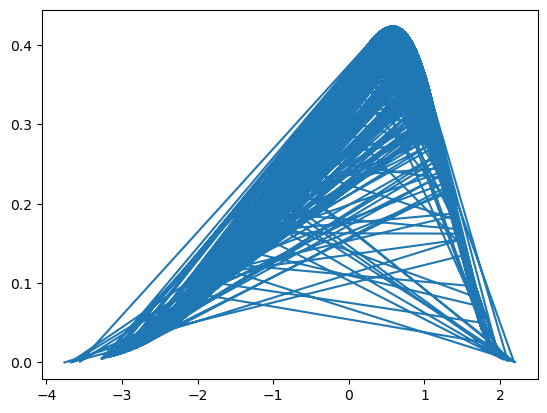

In [305]:
plt.plot(george_1_train_sample, stats.exponweib.pdf(george_1_train_sample, *stats.exponweib.fit(george_1_train_sample, 1, 1)))

In [165]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(george_1_train_sample)

p value for norm = 7.486907866301419e-103
p value for exponweib = 9.83962123873793e-86
p value for weibull_max = 2.883338569348903e-65
p value for weibull_min = 3.443451138186443e-74
p value for pareto = 0.0
p value for genextreme = 2.822056009527433e-65
Best fitting distribution: weibull_max
Best p value: 2.883338569348903e-65
Parameters for the best fit: (2.3855886231430343, 2.2036923525752767, 2.5250080565258117)


In [166]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(george_1_train)

p value for norm = 7.486907866301419e-103
p value for exponweib = 9.83962123873793e-86
p value for weibull_max = 2.883338569348903e-65
p value for weibull_min = 3.443451138186443e-74
p value for pareto = 0.0
p value for genextreme = 2.822056009527433e-65
Best fitting distribution: weibull_max
Best p value: 2.883338569348903e-65
Parameters for the best fit: (2.3855886231430343, 2.2036923525752767, 2.5250080565258117)


In [167]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(jackson_1_train_sample)

p value for norm = 4.805670672618289e-58
p value for exponweib = 0.0
p value for weibull_max = 1.0319212589990532e-23
p value for weibull_min = 2.8268755040977624e-37
p value for pareto = 0.0
p value for genextreme = 9.859240546598261e-24
Best fitting distribution: weibull_max
Best p value: 1.0319212589990532e-23
Parameters for the best fit: (2.328122692820576, 2.1451017461692112, 2.454399390777017)


In [168]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(jackson_1_train)

p value for norm = 4.805670672618289e-58
p value for exponweib = 0.0
p value for weibull_max = 1.0319212589990532e-23
p value for weibull_min = 2.8268755040977624e-37
p value for pareto = 0.0
p value for genextreme = 9.859240546598261e-24
Best fitting distribution: weibull_max
Best p value: 1.0319212589990532e-23
Parameters for the best fit: (2.328122692820576, 2.1451017461692112, 2.454399390777017)


In [169]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(nicolas_1_train_sample)

p value for norm = 1.800548260433273e-56
p value for exponweib = 4.526445931746673e-40
p value for weibull_max = 9.250867751132676e-47
p value for weibull_min = 8.89384466147027e-75
p value for pareto = 0.0
p value for genextreme = 9.330153160752234e-47
Best fitting distribution: exponweib
Best p value: 4.526445931746673e-40
Parameters for the best fit: (45.139151926012715, 78.10466999529791, -284.3885302974552, 279.1641151345324)


In [170]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(nicolas_1_train)

p value for norm = 1.800548260433273e-56
p value for exponweib = 4.526445931746673e-40
p value for weibull_max = 9.250867751132676e-47
p value for weibull_min = 8.89384466147027e-75
p value for pareto = 0.0
p value for genextreme = 9.330153160752234e-47
Best fitting distribution: exponweib
Best p value: 4.526445931746673e-40
Parameters for the best fit: (45.139151926012715, 78.10466999529791, -284.3885302974552, 279.1641151345324)


In [171]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(theo_1_train_sample)

p value for norm = 1.0194017987732583e-71
p value for exponweib = 4.462636809996485e-82
p value for weibull_max = 9.310662352335229e-57
p value for weibull_min = 4.796471639419751e-66
p value for pareto = 0.0
p value for genextreme = 9.911102719798118e-57
Best fitting distribution: genextreme
Best p value: 9.911102719798118e-57
Parameters for the best fit: (0.3196151893238057, -0.3487139434048472, 1.0059914811899004)


In [172]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(theo_1_train)

p value for norm = 1.0194017987732583e-71
p value for exponweib = 4.462636809996485e-82
p value for weibull_max = 9.310662352335229e-57
p value for weibull_min = 4.796471639419751e-66
p value for pareto = 0.0
p value for genextreme = 9.911102719798118e-57
Best fitting distribution: genextreme
Best p value: 9.911102719798118e-57
Parameters for the best fit: (0.3196151893238057, -0.3487139434048472, 1.0059914811899004)


In [173]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(lucas_test)

p value for norm = 7.887008566029111e-104
p value for exponweib = 6.371948694544215e-98
p value for weibull_max = 4.398730117433886e-87
p value for weibull_min = 2.767531543584102e-93
p value for pareto = 0.0
p value for genextreme = 4.7872328670541805e-87
Best fitting distribution: genextreme
Best p value: 4.7872328670541805e-87
Parameters for the best fit: (0.27270033958574347, -0.38046021058040547, 0.9749063653264103)


In [174]:
params = {}
best_dist, best_p, params[best_dist] = get_best_distribution(yweweler_test)

p value for norm = 7.887008566029111e-104
p value for exponweib = 6.371948694544215e-98
p value for weibull_max = 4.398730117433886e-87
p value for weibull_min = 2.767531543584102e-93
p value for pareto = 0.0
p value for genextreme = 4.7872328670541805e-87
Best fitting distribution: genextreme
Best p value: 4.7872328670541805e-87
Parameters for the best fit: (0.27270033958574347, -0.38046021058040547, 0.9749063653264103)


In [162]:
scipy.stats.ks_2samp(george_1_train, george_1_train_sample, alternative='two-sided', mode='auto')

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=-3.7618422508239746, statistic_sign=1)

In [163]:
scipy.stats.ks_2samp(george_1_train_sample, lucas_test, alternative='two-sided', mode='auto')

KstestResult(statistic=0.04541538461538462, pvalue=1.0762255449272356e-15, statistic_location=-1.2543905973434448, statistic_sign=1)

In [164]:
scipy.stats.ks_2samp(george_1_train, yweweler_test, alternative='two-sided', mode='auto')

KstestResult(statistic=0.04541538461538462, pvalue=1.0762255449272356e-15, statistic_location=-1.2543905973434448, statistic_sign=1)

In [175]:
scipy.stats.ks_2samp(lucas_test, yweweler_test, alternative='two-sided', mode='auto')

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=-3.064708948135376, statistic_sign=1)

In [176]:
scipy.stats.ks_2samp(theo_1_train_sample, yweweler_test, alternative='two-sided', mode='auto')

KstestResult(statistic=0.02973426573426574, pvalue=5.682996537780036e-07, statistic_location=0.0007900783481697513, statistic_sign=-1)

In [177]:
scipy.stats.ks_2samp(theo_1_train_sample, lucas_test, alternative='two-sided', mode='auto')

KstestResult(statistic=0.02973426573426574, pvalue=5.682996537780036e-07, statistic_location=0.0007900783481697513, statistic_sign=-1)

In [178]:
scipy.stats.ks_2samp(george_1_train_sample, lucas_test, alternative='two-sided', mode='auto')

KstestResult(statistic=0.04541538461538462, pvalue=1.0762255449272356e-15, statistic_location=-1.2543905973434448, statistic_sign=1)

CNN Model, inspired by https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610

In [180]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 10

In [181]:
def get_CNN(filters:list(), kernels:list(), activations:list(), dropout:float, pooling:int):
    '''
        The CNN is made of Conv1D layers, in some order described by the user, usually followed by a dropout layer in order 
        to avoid overfitting. After it they're followed by a Pooling filter, in order to drop the number of parameters and save
        computational costs. At the end there's a Flattening layer and a Fully connected - Dense layer for the output.
    '''
    if len(filters) != len(kernels) or len(filters) != len(activations):
        return None
    
    model = keras.Sequential()
    
    for i in range(0, len(filters), 2):
        if i == 0:        
            model.add(Conv1D(filters=filters[i], kernel_size=kernels[i], activation=activations[i], input_shape=(n_timesteps,n_features)))
        else:
            model.add(Conv1D(filters=filters[i], kernel_size=kernels[i], activation=activations[i]))
        if i+1 == len(filters):
            continue
        model.add(Conv1D(filters=filters[i+1], kernel_size=kernels[i+1], activation=activations[i+1]))
        model.add(Dropout(dropout))
        model.add(MaxPooling1D(pool_size=pooling))

    
    model.add(Flatten())
    model.add(Dense(50, activation='relu')) # this was 150, but changing it to 3 layers of 50 improved results
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

As was the case with the LSTM, here as well, and NN in general, the more we increase the size of the network the more complexity we can capture. To clarify further, we can increse the complexity of a NN, CNN in this case, in one of two ways (this is an oversimplification and excludes other more fine ways: number of filters, kernel sizes, stride, complexity of activation function, i.e. ceteris paribus - all else being equal): we either increase the depth, or widht of it. 

Now in accordance with the universal approximation theorem, if we had just one hidden layer, with a non-linear activation function, we can already approximate any (Borel measurable) function, given enough training data. On the extreme, that would mean that just having one, increadibly wide, hidden layer, and huge amount of data, we can train a pretty decent network. The problem with this extreme is that, shallow (wide) networks are really good at memorizing, but bad at generalizing. So if we gave it every possible input it could ever encounter then yes, but since that is hardly the case, this type of network would perform badly on new data, which it hasn't seen. Also as we have seen, the wider the network, the more time it takes to get trained (ceteris paribus).

The advantage of adding layers, in depth, is that by increasing the number of layers, we increase the number of intermediate features that the network can learn. So in the case of CNN, we can make the analogy that the first layers might recognize basic things, like edges or colours (again these are mainly used in Computer Vision tasks, not NLP, so this is the running example), but the later layers will be able to recognize more complex shapes and formes, like faces, objects, patterns, etc. This means that the deeper the network the more generalizable they are. That is also one of the reason why, it's been shown that using transfer learning of networks from different domains gives better results (say transfer learning from NN trained on images, to NN that will work on NLP).

In [184]:
train_X.shape[1]

325

In [185]:
# for CNN relu gives better results than tanh, in our case
model_cnn = get_CNN([train_X.shape[1], 84, 16], [5, 2, 2], ['relu', 'relu', 'relu'], 0.25, 2)

In [186]:
verbose, epochs, batch_size = 1, 100, 64

In [187]:
history = model_cnn.fit(train_X, encoded_train, epochs=epochs, batch_size=batch_size, validation_data=(dev_X, encoded_dev), shuffle=True, verbose=verbose)

Epoch 1/100
32/32 [==============================] - 3s 81ms/step - loss: 2.1619 - acc: 0.1555 - val_loss: 2.2906 - val_acc: 0.1791
Epoch 2/100
32/32 [==============================] - 3s 78ms/step - loss: 2.0479 - acc: 0.1925 - val_loss: 2.3010 - val_acc: 0.1831
Epoch 3/100
32/32 [==============================] - 2s 78ms/step - loss: 2.0064 - acc: 0.1940 - val_loss: 2.2240 - val_acc: 0.1871
Epoch 4/100
32/32 [==============================] - 3s 82ms/step - loss: 1.9914 - acc: 0.2015 - val_loss: 2.2939 - val_acc: 0.1932
Epoch 5/100
32/32 [==============================] - 2s 78ms/step - loss: 1.9471 - acc: 0.1980 - val_loss: 2.2633 - val_acc: 0.2072
Epoch 6/100
32/32 [==============================] - 2s 78ms/step - loss: 1.9248 - acc: 0.2025 - val_loss: 2.5385 - val_acc: 0.2072
Epoch 7/100
32/32 [==============================] - 3s 79ms/step - loss: 1.8980 - acc: 0.2045 - val_loss: 2.3834 - val_acc: 0.1972
Epoch 8/100
32/32 [==============================] - 3s 80ms/step - loss: 1.

In [188]:
_, accuracy = model_cnn.evaluate(test_X, encoded_test, batch_size=batch_size, verbose=0)

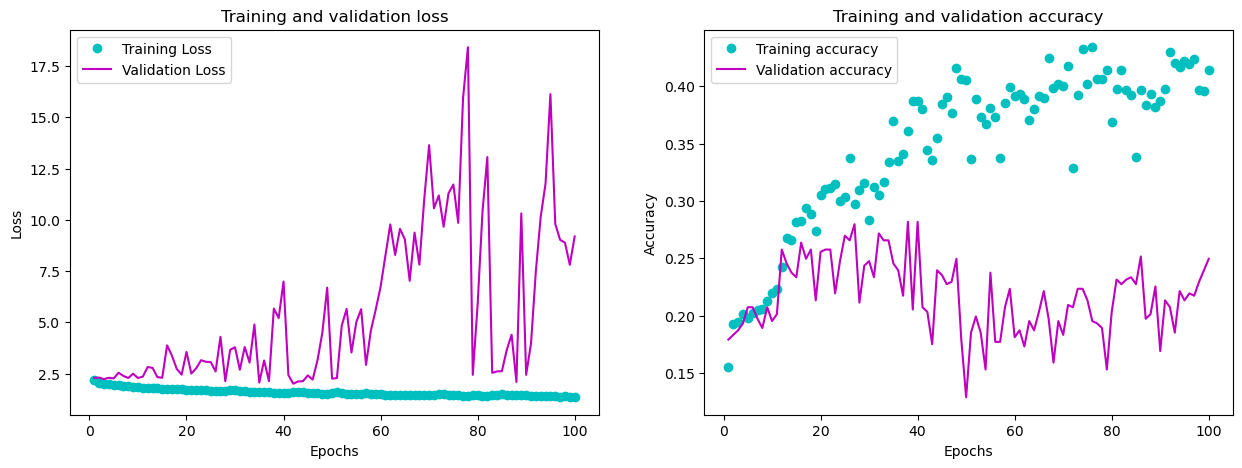

In [189]:
history_dict_cnn=history.history
loss_values=history_dict_cnn['loss']
acc_values=history_dict_cnn['acc']
val_loss_values = history_dict_cnn['val_loss']
val_acc_values=history_dict_cnn['val_acc']
epoch=range(1,epochs + 1) # need an x-axis
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epoch,loss_values,'co',label='Training Loss')
ax1.plot(epoch,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epoch,acc_values,'co', label='Training accuracy')
ax2.plot(epoch,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [191]:
dev_pred_cnn_encoded = model_cnn.predict(dev_X).astype("int")

16/16 [==============================] - 0s 13ms/step


In [192]:
dev_pred_cnn=np.argmax(dev_pred_cnn_encoded, axis=1)

In [193]:
score_cnn = accuracy_score(dev_y, dev_pred_cnn)

In [196]:
score_cnn, accuracy

(0.09456740442655935, 0.26838967204093933)

In [194]:
cm_cnn = confusion_matrix(dev_y, dev_pred_cnn)

Transformers Model, inspired by https://keras.io/examples/timeseries/timeseries_transformer_classification/

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
n_classes = 10
def get_Transformer(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    # added improves results
    x = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]
head_size = 32
num_heads = 8
num_transformer_blocks = 8
mlp_units = [64]
mlp_dropout = 0.2
dropout = 0.2
epochs = 2
lr = 5e-4
patience = 10

In [ ]:
model_transformer = get_Transformer(
    input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=4,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    mlp_dropout=mlp_dropout,
    dropout=dropout,
)

In [ ]:
model_transformer.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    metrics=["acc"],
)

# for testing
model_transformer.summary()

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)]

In [ ]:
history = model_transformer.fit(
    train_X,
    encoded_train,
    validation_data=(dev_X, encoded_dev),
    epochs=epochs,
    batch_size=64,
    callbacks=callbacks,
)

In [ ]:
evaluation = model_transformer.evaluate(test_X, encoded_test, verbose=0)


In [ ]:
history_dict_transformer=history.history
loss_values=history_dict_transformer['loss']
acc_values=history_dict_transformer['acc']
val_loss_values = history_dict_transformer['val_loss']
val_acc_values=history_dict_transformer['val_acc']
epoch=range(1,epochs + 1) # need an x-axis
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epoch,loss_values,'co',label='Training Loss')
ax1.plot(epoch,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epoch,acc_values,'co', label='Training accuracy')
ax2.plot(epoch,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [ ]:
dev_pred_transformer_encoded = model_transformer.predict(dev_X).astype("int")

In [ ]:
dev_pred_transformer=np.argmax(dev_pred_transformer_encoded, axis=1)

In [ ]:
score_transformer = accuracy_score(dev_y, dev_pred_transformer)

In [ ]:
cm_transformer = confusion_matrix(dev_y, dev_pred_transformer)

Comparison

https://github.com/Kaleidophon/deep-significance#scenario-4---comparing-more-than-two-models


tl;dr: Use aso() to compare scores for two models. If the returned eps_min < 0.5, A is better than B. The lower eps_min, the more confident the result (we recommend to check eps_min < 0.2 and record eps_min alongside experimental results).

In [ ]:
lstm_np = np.array(history_dict_lstm['acc'])
cnn_np = np.array(history_dict_cnn['acc'])
transformer_np = np.array(history_dict_transformer['acc'])


my_models_scores = np.stack([lstm_np, cnn_np, transformer_np], axis=0)
eps_min = multi_aso(my_models_scores, confidence_level=0.95, return_df=True)

## Task III (Open Ended)
1. Consider the case where we have speech data from a single speaker (e.g., george). Train your models on this subset of the data. What do you observe? How does this affect the model performance? 

2. Even though a model is trained on a single speaker, we would like the model to generalizes to any speaker. To this end, one can use data augmentation techniques to artificially create more samples for each class. Some of these augmentations can be applied on the spectrogram (e.g., SpecAugment https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html), and other can be applied on the raw waveform before creating the spectrogram such as pitch manipulation (https://github.com/facebookresearch/WavAugment). Explore the effect of one type of augmentation from each type. Report your observation and anaylze the confusion matrices.

3. Data augmentation techniques create different "views" of each training sample in a stochastic or determinstic approach. One can leaverage speech data augmentation to create views for training a neural network in a contrastive learning setting with margin-based objective function (for more info, read http://proceedings.mlr.press/v130/al-tahan21a/al-tahan21a.pdf). Implement at least one model using a contrastive loss based on different views of the training samples. Does this model improve over the model without contrastive learning? Report and discuss your observations. 

For more information on the contrastive learning framework, you can refer to this paper
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9226466

Code for augmentation inspired by https://jonathanbgn.com/2021/08/30/audio-augmentation.html. It is used mainly to demonstrate the effects of data augmentation, i.e. it improves prediction accuracy.

In [197]:
class RandomClip:
    '''
        Create a new audio sample, from a random clip from the original.
    '''
    def __init__(self, sample_rate, clip_length):
        self.clip_length = clip_length
        self.vad = torchaudio.transforms.Vad(
            sample_rate=sample_rate, trigger_level=7.0)

    def __call__(self, audio_data):
        audio_length = audio_data.shape[0]
        if audio_length > self.clip_length:
            offset = random.randint(0, audio_length-self.clip_length)
            audio_data = audio_data[offset:(offset+self.clip_length)]

        # remove silences at the beggining/end
        return self.vad(audio_data) 

# clip_transform = RandomClip(SAMPLING_RATE, 1000*len(x)) # 8 seconds clip
# transformed_audio = clip_transform(sdr_df[sdr_df['file'] == sample_wav_file]['file'])

In [198]:
class RandomSpeedChange:
    ''' 
        Change the speed of the audio.
    '''
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate

    def __call__(self, audio_data):
        speed_factor = random.choice([0.9, 1.0, 1.1])
        if speed_factor == 1.0: # no change
            return audio_data

        # change speed and resample to original rate:
        sox_effects = [
            ["speed", str(speed_factor)],
            ["rate", str(self.sample_rate)],
        ]
        transformed_audio, _ = torchaudio.sox_effects.apply_effects_tensor(
            audio_data, self.sample_rate, sox_effects)
        return transformed_audio

In [217]:
class ComposeTransform:
    '''
        Add the transformations
    '''
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, audio_data):
        for t in self.transforms:
            audio_data = t(audio_data)
        return audio_data


compose_transform = ComposeTransform([
    RandomClip(sample_rate=SAMPLING_RATE, clip_length=3428),
    RandomSpeedChange(SAMPLING_RATE)])

In [200]:
def add_white_noise(audio, var=1):
  '''
    Will add white noise to it.
  '''
  white_noise = torch.zeros(audio.shape)
  white_noise = white_noise + (var**0.5)*torch.randn(audio.shape)
  return audio + white_noise

In [218]:
def augment_data(sdr_df, N=25):
  ''' 
    Will create new augmented data, but it will return it separately from the original data. 
    Needs to be concatinated further. Also X_augmented is 2D, (#samples, length of samples),
    while X[_train] is 3D (#samples, length of samples, 1)
  '''
  X_train_augmented = []
  X_dev_augmented = []
  X_test_augmented = []

  y_train_augmented = []
  y_dev_augmented = []
  y_test_augmented = []

  for index, row in sdr_df.iterrows():
      sample_wav_file = row["file"]
      x, sr = librosa.load(path + sample_wav_file, sr=SAMPLING_RATE)
      clip_length = len(x)

      audio_file, sample_rate = torchaudio.load(path + sample_wav_file)      
      transformed_audio = compose_transform(audio_file)
      add_white_noise(transformed_audio)

      # transformed_audio = np.array(transformed_audio) transformed_audio is Tensor, so -> numpy (but has shape (1, ...), and we need (..., ))
      melspectrogram = extract_melspectrogram(transformed_audio.numpy().reshape(transformed_audio.numpy().shape[1]), sr, num_mels=13)
      
      downsample = downsample_spectrogram(melspectrogram, N)
      label = row["label"]
      split = row["split"]
      
      if split == "TRAIN":
          X_train_augmented.append(downsample)
          y_train_augmented.append(label)
      
      if split == "DEV":
          X_dev_augmented.append(downsample)
          y_dev_augmented.append(label)
          
      if split == "TEST":
          X_test_augmented.append(downsample)
          y_test_augmented.append(label)

  X_train_augmented = np.array(X_train_augmented)
  y_train_augmented = np.array(y_train_augmented)
  X_dev_augmented = np.array(X_dev_augmented)
  y_dev_augmented = np.array(y_dev_augmented)
  X_test_augmented = np.array(X_test_augmented)
  y_test_augmented = np.array(y_test_augmented)

  return X_train_augmented, X_dev_augmented, X_test_augmented, y_train_augmented, y_dev_augmented, y_test_augmented

In [257]:
X_train_augmented, X_dev_augmented, X_test_augmented, y_train_augmented, y_dev_augmented, y_test_augmented = augment_data(sdr_df)

In [258]:
X_train_augmented.shape, X_dev_augmented.shape, X_test_augmented.shape, y_train_augmented.shape, y_dev_augmented.shape, y_test_augmented.shape

((2000, 325), (497, 325), (503, 325), (2000,), (497,), (503,))

In [259]:
X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], X_train_augmented.shape[1], 1)
X_test_augmented = X_test_augmented.reshape(X_test_augmented.shape[0], X_test_augmented.shape[1], 1)
X_dev_augmented = X_dev_augmented.reshape(X_dev_augmented.shape[0], X_dev_augmented.shape[1], 1)

In [222]:
X_train_augmented.shape, train_X.shape

((2000, 325, 1), (2000, 325))

In [240]:
# run only once, then skip
# X_train_concatenated = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
# X_test_concatenated = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
# X_dev_concatenated = dev_X.reshape(dev_X.shape[0], dev_X.shape[1], 1)

# y_train_concatenated = train_y
# y_test_concatenated = test_y
# y_dev_concatenated = dev_y

In [260]:
X_train_concatenated.shape, X_test_concatenated.shape, X_dev_concatenated.shape, y_train_concatenated.shape, y_test_concatenated.shape, y_dev_concatenated.shape

((8000, 325, 1), (2012, 325, 1), (1988, 325, 1), (8000,), (2012,), (1988,))

In [283]:
for i in range (0, 15):
    X_train_augmented, X_dev_augmented, X_test_augmented, y_train_augmented, y_dev_augmented, y_test_augmented = augment_data(sdr_df)

    X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], X_train_augmented.shape[1], 1)
    X_test_augmented = X_test_augmented.reshape(X_test_augmented.shape[0], X_test_augmented.shape[1], 1)
    X_dev_augmented = X_dev_augmented.reshape(X_dev_augmented.shape[0], X_dev_augmented.shape[1], 1)

    X_train_concatenated = np.concatenate([X_train_augmented, X_train_concatenated], axis=0)
    X_test_concatenated = np.concatenate([X_test_augmented, X_test_concatenated], axis=0)
    X_dev_concatenated = np.concatenate([X_dev_augmented, X_dev_concatenated], axis=0)

    y_train_concatenated = np.concatenate([y_train_augmented, y_train_concatenated], axis=0)
    y_test_concatenated = np.concatenate([y_test_augmented, y_test_concatenated], axis=0)
    y_dev_concatenated = np.concatenate([y_dev_augmented, y_dev_concatenated], axis=0)

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [261]:
X_train_concatenated = np.concatenate([X_train_augmented, X_train_concatenated], axis=0)
X_test_concatenated = np.concatenate([X_test_augmented, X_test_concatenated], axis=0)
X_dev_concatenated = np.concatenate([X_dev_augmented, X_dev_concatenated], axis=0)

y_train_concatenated = np.concatenate([y_train_augmented, y_train_concatenated], axis=0)
y_test_concatenated = np.concatenate([y_test_augmented, y_test_concatenated], axis=0)
y_dev_concatenated = np.concatenate([y_dev_augmented, y_dev_concatenated], axis=0)

In [300]:
X_train_concatenated.shape, X_test_concatenated.shape, X_dev_concatenated.shape, y_train_concatenated.shape, y_test_concatenated.shape, y_dev_concatenated.shape

((60000, 325, 1),
 (15090, 325, 1),
 (14910, 325, 1),
 (60000,),
 (15090,),
 (14910,))

In [287]:
np.savetxt("X_train_concatenated", X_train_concatenated.shape[:2], delimiter=',')

In [289]:
X_train_concatenated

array([[[-2.68952966],
        [-2.55415082],
        [ 0.6590184 ],
        ...,
        [-0.37030998],
        [ 1.26804996],
        [ 2.02378917]],

       [[-2.21006346],
        [-1.85448725],
        [-1.94900894],
        ...,
        [-1.18351613],
        [-1.46569066],
        [-0.98121238]],

       [[-2.37004948],
        [ 0.60511169],
        [ 0.73997712],
        ...,
        [-0.64022869],
        [-0.8756861 ],
        [-1.31766284]],

       ...,

       [[-0.26338601],
        [ 0.54261521],
        [-0.74287682],
        ...,
        [-1.75038226],
        [-1.92610598],
        [-2.07448077]],

       [[-1.71235299],
        [ 0.00518701],
        [ 0.81819094],
        ...,
        [-0.77222549],
        [-0.91043571],
        [-0.93815309]],

       [[-2.97021198],
        [-1.16841239],
        [ 0.65249986],
        ...,
        [-1.42058394],
        [-0.78918118],
        [-1.15899742]]])

In [290]:
encoded_train_augmented = to_categorical(y_train_concatenated)
encoded_dev_augmented = to_categorical(y_dev_concatenated)
encoded_test_augmented = to_categorical(y_test_concatenated)

In [291]:
history_augmented = model_cnn.fit(X_train_concatenated, encoded_train_augmented, epochs=epochs, batch_size=batch_size, validation_data=(dev_X, encoded_dev), shuffle=True, verbose=verbose)

Epoch 1/100
938/938 [==============================] - 72s 76ms/step - loss: 1.0929 - acc: 0.4967 - val_loss: 5.0041 - val_acc: 0.2837
Epoch 2/100
938/938 [==============================] - 76s 81ms/step - loss: 1.1224 - acc: 0.4926 - val_loss: 3.8391 - val_acc: 0.2757
Epoch 3/100
938/938 [==============================] - 75s 80ms/step - loss: 1.0921 - acc: 0.4973 - val_loss: 5.1815 - val_acc: 0.2757
Epoch 4/100
938/938 [==============================] - 75s 80ms/step - loss: 1.1205 - acc: 0.4914 - val_loss: 14.7259 - val_acc: 0.2696
Epoch 5/100
938/938 [==============================] - 76s 81ms/step - loss: 1.0941 - acc: 0.4947 - val_loss: 7.2479 - val_acc: 0.2877
Epoch 6/100
938/938 [==============================] - 77s 82ms/step - loss: 1.1103 - acc: 0.4941 - val_loss: 3.8837 - val_acc: 0.2596
Epoch 7/100
938/938 [==============================] - 77s 82ms/step - loss: 1.0947 - acc: 0.4968 - val_loss: 4.4775 - val_acc: 0.2817
Epoch 8/100
938/938 [==============================] -

In [292]:
enc = to_categorical(test_y)

In [278]:
test_X.shape

(503, 325)

In [296]:
_, accuracy_augmented = model_cnn.evaluate(X_test_concatenated, encoded_test_augmented, batch_size=batch_size, verbose=0)

In [298]:
accuracy_augmented

0.24347250163555145

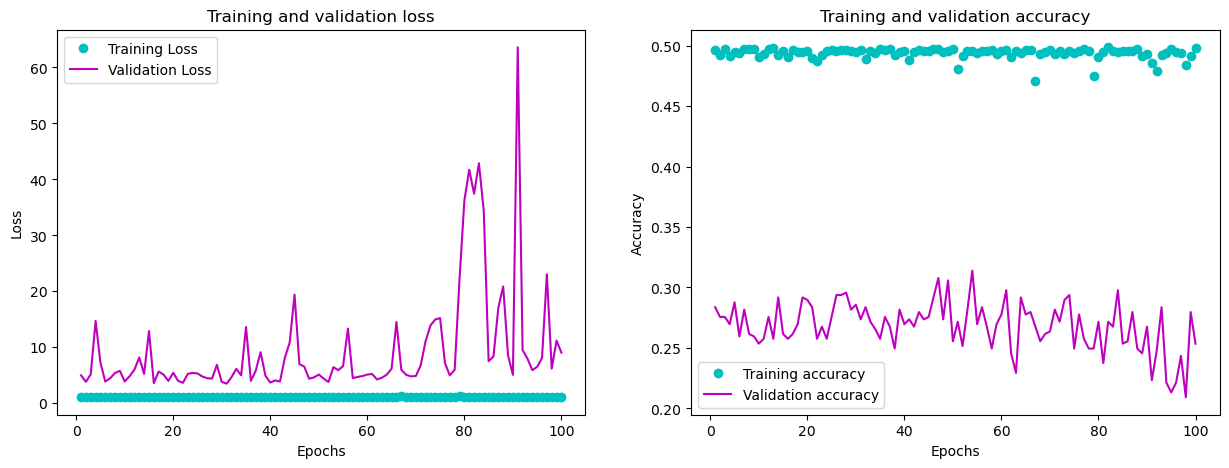

In [301]:
history_dict_cnn=history_augmented.history
loss_values=history_dict_cnn['loss']
acc_values=history_dict_cnn['acc']
val_loss_values = history_dict_cnn['val_loss']
val_acc_values=history_dict_cnn['val_acc']
epoch=range(1,epochs + 1) # need an x-axis
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epoch,loss_values,'co',label='Training Loss')
ax1.plot(epoch,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epoch,acc_values,'co', label='Training accuracy')
ax2.plot(epoch,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [ ]:
dev_pred_cnn_encoded_augmented = model_cnn.predict(X_dev_concatenated).astype("int")

In [ ]:
dev_pred_cnn_augmented=np.argmax(dev_pred_cnn_encoded_augmented, axis=1)

In [ ]:
score_cnn_augmented = accuracy_score(y_dev_concatenated, dev_pred_cnn_augmented)

In [ ]:
cm_cnn_augmented = confusion_matrix(y_dev_augmented, dev_pred_cnn)

In [ ]:
score_cnn, score_cnn_augmented, cm_cnn, cm_cnn_augmented

In [ ]:
type(history_augmented.history), type(history_dict_cnn)

In [ ]:
augmented_np = np.array(history_augmented.history['acc'])
cnn_np = np.array(history_dict_cnn['acc'])


my_models_scores = np.stack([augmented_np, cnn_np], axis=0)
eps_min = multi_aso(my_models_scores, confidence_level=0.95, return_df=True)

Delete after this, trials.

https://keras.io/examples/vision/supervised-contrastive-learning/

In [ ]:
num_classes = 10
input_shape = X_train_concatenated.shape

In [ ]:
def create_encoder(X_train_concatenated):

    augmented_data = X_train_concatenated.reshape(1, 4000, 260, 1)
    resnet = keras.applications.ResNet101V2(
        include_top=True, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    outputs = resnet(augmented_data)
    # print(type(outputs), outputs.shape)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    # return model


encoder = create_encoder(X_train_concatenated)
# encoder.summary()

In [ ]:
def make_pairs(audios, labels):
	# initialize two empty lists to hold the (audios, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairAudios = []
	pairLabels = []
	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
	# loop over all audios
	for idxA in range(len(audios)):
		# grab the current audio and label belonging to the current
		# iteration
		currentAudio = audios[idxA]
		label = labels[idxA]
		# randomly pick an audio that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posAudio = audios[idxB]
		# prepare a positive pair and update the audios and labels
		# lists, respectively
		pairAudios.append([currentAudio, posAudio])
		pairLabels.append([1])
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an audio corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negAudio = audios[np.random.choice(negIdx)]
		# prepare a negative pair of audios and update our lists
		pairAudios.append([currentAudio, negAudio])
		pairLabels.append([0])
	# return a 2-tuple of our audio pairs and labels
	return (np.array(pairAudios), np.array(pairLabels))

In [ ]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))


In [ ]:
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

In [ ]:
# Constructing our audio pairs
(pairTrain, labelTrain) = make_pairs(X_train_augmented, y_train_augmented)
(pairTest, labelTest) = make_pairs(X_test_augmented, y_test_augmented)

In [ ]:
imgA = Input(input_shape[1], input_shape[2])
imgB = Input(input_shape[1], input_shape[2]
featureExtractor = build_siamese_model(config.IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
# finally, construct the siamese network
distance = Lambda(utils.euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!python --version